In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=6000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def get_inputs(in_dim,n_labels):
    inputs_= tf.placeholder(tf.float32,[None,in_dim])
    targets= tf.placeholder(tf.float32,[None,n_labels])
    learning_rate=tf.placeholder(tf.float32)
    return inputs_,targets,learning_rate

In [33]:
def myswish(x):
    return x*tf.nn.sigmoid(x)

def myswish_beta(x):
    beta=tf.Variable(initial_value=1.0,trainable=True,name='swish_beta')
    return x*tf.nn.sigmoid(beta*x) #trainable parameter beta

functions={'identity':tf.identity,'sigmoid':tf.nn.sigmoid,'relu':tf.nn.relu,'swish_1':myswish,'swish_beta':myswish_beta}

In [34]:
def get_graph(inputs_,targets,learning_rate,nodes1,nodes2,func,sigma=1):
    activation=functions[func]
    
    weights1=tf.Variable(tf.truncated_normal([in_dim,nodes1],stddev=sigma))
    bias1= tf.Variable(tf.truncated_normal([nodes1],stddev=sigma))

    weights2=tf.Variable(tf.truncated_normal([nodes1,nodes2],stddev=sigma))
    bias2= tf.Variable(tf.truncated_normal([nodes2],stddev=sigma))

    weights3=tf.Variable(tf.truncated_normal([nodes2,n_labels],stddev=sigma))
    bias3= tf.Variable(tf.truncated_normal([n_labels],stddev=sigma))

    layer1=tf.add(tf.matmul(inputs_,weights1),bias1)
    layer1=activation(layer1)

    layer2=tf.add(tf.matmul(layer1,weights2),bias2)
    layer2=activation(layer2)

    layer3=tf.add(tf.matmul(layer2,weights3),bias3)
    logits=layer3

    accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,axis=1),tf.cast(tf.argmax(targets,axis=1),dtype=tf.int64)),dtype=tf.float32))

    cost=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=targets))

    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    return accuracy, cost, optimizer

In [35]:
def get_batch(batch_size=128):
    max_size=mnist.train.images.shape[0]
    for idx in range(0,max_size,batch_size):
        batch_x=mnist.train.images[idx:idx+batch_size,:]
        batch_y=mnist.train.labels[idx:idx+batch_size]
        batch_y=np.eye(n_labels)[batch_y]
        yield batch_x,batch_y

In [52]:
in_dim=784 #28x28
nodes1=256 #first hidden layer: 256 neurons
nodes2=64 #second hidden layer: 64 neurons
n_labels=10 #output layer: 10 classes
lr=1e-4
epochs=10
batch_size=64
sigma=1.0 #decides initialization of weights and biases

In [53]:
for func in ['identity','sigmoid','relu','swish_1','swish_beta']:
    tf.reset_default_graph()
    graph=tf.get_default_graph()
    inputs_,targets,learning_rate= get_inputs(in_dim,n_labels)
    acc,loss,opt=get_graph(inputs_,targets,learning_rate,nodes1,nodes2,func,sigma)
    train_acc=[]
    valid_acc=[]
    #isbeta= len([n.name for n in tf.get_default_graph().as_graph_def().node if 'swish_beta' in n.name])>0
    #sorry, this looks slightly convoluted, we just want to find whether a tensor by name 'swish_beta' exists

    with tf.Session(graph=graph) as sess:
        saver=tf.train.Saver()
        tf.set_random_seed(0)
        sess.run(tf.global_variables_initializer())
        if func=='swish_beta':
            beta_values=[]
            beta_=graph.get_tensor_by_name('swish_beta:0')

        for e in range(epochs):
            count=0
            max_size=mnist.train.images.shape[0]
            for batch_x,batch_y in get_batch(batch_size):
                feed={inputs_:batch_x,targets:batch_y,learning_rate:lr}
                tloss,tacc,_=sess.run([loss,acc,opt],feed_dict=feed)
                train_acc.append(tacc)
                if func=='swish_beta':
                    beta_values.append(beta_.eval())
                    #print('beta={:.3f}'.format(beta_.eval()))
                count+=1
                feed={inputs_:mnist.validation.images,targets:np.eye(n_labels)[mnist.validation.labels]}
                valid=sess.run(acc,feed_dict=feed)
                valid_acc.append(valid)
                if count%100==0:
                    print('Activation: {}, Epoch {}/{},Batch #{}. Training loss={:.3f}, validation accuracy: {:.3f}'\
                          .format(func,e+1,epochs,count,tloss,valid))
        saver.save(sess,'checkpoints/'+func+'/model')
        with open(func+'.p','wb') as f:
            pickle.dump((train_acc,valid_acc),f)

Activation: identity, Epoch 1/10,Batch #100. Training loss=240.048, validation accuracy: 0.041
Activation: identity, Epoch 1/10,Batch #200. Training loss=126.864, validation accuracy: 0.065
Activation: identity, Epoch 1/10,Batch #300. Training loss=99.326, validation accuracy: 0.098
Activation: identity, Epoch 1/10,Batch #400. Training loss=84.364, validation accuracy: 0.139
Activation: identity, Epoch 1/10,Batch #500. Training loss=55.749, validation accuracy: 0.193
Activation: identity, Epoch 1/10,Batch #600. Training loss=56.197, validation accuracy: 0.252
Activation: identity, Epoch 1/10,Batch #700. Training loss=41.315, validation accuracy: 0.303
Activation: identity, Epoch 1/10,Batch #800. Training loss=42.234, validation accuracy: 0.356
Activation: identity, Epoch 2/10,Batch #100. Training loss=39.989, validation accuracy: 0.440
Activation: identity, Epoch 2/10,Batch #200. Training loss=27.578, validation accuracy: 0.477
Activation: identity, Epoch 2/10,Batch #300. Training loss

True

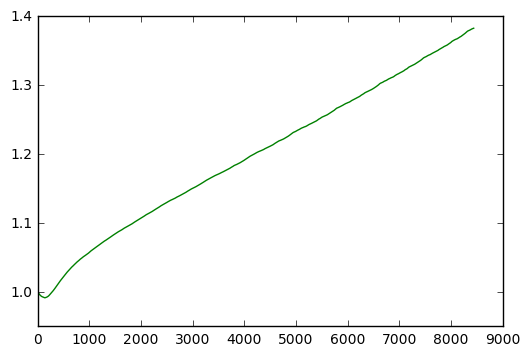

In [54]:
plt.plot(beta_values,'g')
plt.xlabel='Training step #'
plt.ylabel='beta'
plt.show()

In [23]:
functions.keys()

dict_keys(['swish_1', 'swish_beta', 'sigmoid', 'identity', 'relu'])

In [55]:
colors={'identity':'red','sigmoid':'green','relu':'blue','swish_1':'orange','swish_beta':'firebrick'}

In [56]:
from bokeh.plotting import figure, output_notebook, show

In [57]:
p=figure(title='Very bad initialization (sigma={})'.format(sigma))
for func in functions:
    with open(func+'.p','rb') as f:
        _,validation=pickle.load(f)
    p.line(range(len(validation)),validation,legend=func,color=colors[func])
    p.xaxis.axis_label='Training step'
    p.yaxis.axis_label='Validation accuracy'
p.legend.click_policy='hide'
p.legend.location='bottom_right'
output_notebook()
show(p)

Loading BokehJS ...

In [14]:
from bokeh.plotting import output_file
output_file('activations.html',title='Activation functions')
show(p)